# Text Based Exploratory Data Analysis

In [189]:
import os
from os.path import join
from sqlite3 import connect
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from googletrans import Translator
from wordcloud import WordCloud, STOPWORDS

pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Load Data

In [190]:
files = ['../data/raw/' + x for x in os.listdir('../data/raw') if x[-5:] == '.json']

df = pd.read_json(files[0], lines=True)
for file in files[1:]:
    df = df.append(pd.read_json(file, lines=True), ignore_index=True)

In [192]:
df_users = pd.DataFrame(df['user'].tolist())

df_tweets = df.drop(columns=[
    'id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'user',
    'coordinates', 'place', 'quoted_status_id', 'favorited',
    'retweeted', 'retweeted_status', 'matching_rules', 'geo', 
    'filter_level', 'display_text_range', 'contributors',
    'quoted_status', 'quoted_status_id', 'quoted_status_permalink',
    'in_reply_to_screen_name', 'text', 'extended_tweet', 'truncated','extended_entities'
])

df_tweets['user_id_str'] = df['user'].apply(lambda x: x['id_str'])
df_tweets['full_text'] = df.apply(
    lambda row: 
        row['text'] 
        if not row['truncated'] 
        else row['extended_tweet']['full_text'], 
    axis=1
)

df_tweets['hashtags'] = df_tweets['entities'].apply(lambda x: [y['text'] for y in x['hashtags']])
df_tweets['user_mentions'] = df_tweets['entities'].apply(lambda x: [y['name'] for y in x['user_mentions']])

df_tweets.drop_duplicates(subset='id_str', inplace=True)

In [193]:
df_tweets.shape

(20573, 18)

# Wordcloud over User Mentions

In [194]:
user_ms = {}

user_mentions = df_tweets['user_mentions'].tolist()
for user_m in user_mentions:
    for val in user_m:
        if val:
            if val not in user_ms:
                user_ms[val] = 1
            else:
                user_ms[val] += 1

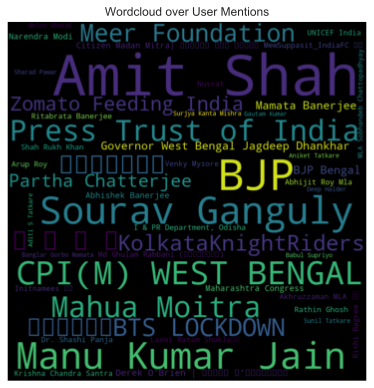

In [195]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', max_words=50,
                min_font_size = 10).generate_from_frequencies(user_ms) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Wordcloud over User Mentions')
  
plt.show() 

# Wordcloud over Hashtags

In [196]:
hashtags = {}

hashes = df_tweets['hashtags'].tolist()
for tag in hashes:
    for val in tag:
        if val:
            val = val.lower()
            if val not in hashtags:
                hashtags[val] = 1
            else:
                hashtags[val] += 1

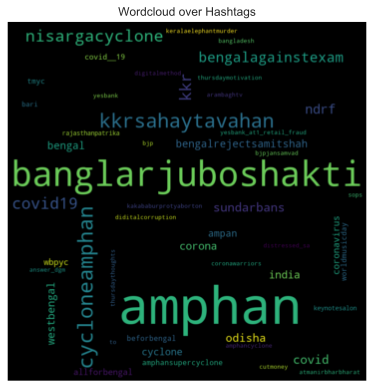

In [197]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', max_words=50,
                min_font_size = 10).generate_from_frequencies(hashtags) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.title('Wordcloud over Hashtags')
plt.tight_layout(pad = 0) 
  
plt.show() 

# Detect undefined languages

In [198]:
und_text = df_tweets[df_tweets['lang']=='und']['full_text'].tolist()
print('No.of tweets with language detected as undefined =',len(und_text))

No.of tweets with language detected as undefined = 820


In [199]:
trans = Translator()
detect = {}

for tweet in und_text:
    lang = trans.detect(tweet).lang
    if lang not in detect.keys():
        detect[lang] = 1
    else:
        detect[lang] += 1

In [200]:
dd = pd.DataFrame(detect.items(), columns=['Language Detected', 'Count']).set_index('Language Detected')
dd

,Count
Language Detected,
hi,24
hiru,2
en,737
mg,13
bn,35
mr,2
enmg,2
cy,1
mrhi,1
